In [219]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import time as time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
from matplotlib.ticker import FormatStrFormatter
from itertools import product
import pandas as pd
from IPython.display import display, HTML

# feature analysis and selection
from sklearn.decomposition import PCA, KernelPCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction import DictVectorizer

# Preprocessing
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OneHotEncoder, Imputer
from sklearn.model_selection import train_test_split, cross_val_score

# Processing
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn import metrics

# SKLearn
from statsmodels.regression.linear_model import OLS
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture


**Data Fields**

SOC, pH, Ca, P, Sand are the five target variables for predictions. The data have been monotonously transformed from the original measurements and thus include negative values.

- PIDN: unique soil sample identifier

- SOC: Soil organic carbon
- pH: pH values
- Ca: Mehlich-3 extractable Calcium
- P: Mehlich-3 extractable Phosphorus

- Sand: Sand content

- m7497.96 - m599.76: There are 3,578 mid-infrared absorbance measurements. For example, the "m7497.96" column is the absorbance at wavenumber 7497.96 cm-1. We suggest you to remove spectra CO2 bands which are in the region m2379.76 to m2352.76, but you do not have to.

- Depth: Depth of the soil sample (2 categories: "Topsoil", "Subsoil")

We have also included some potential spatial predictors from remote sensing data sources. Short variable descriptions are provided below and additional descriptions can be found at AfSIS data. The data have been mean centered and scaled.

- BSA: average long-term Black Sky Albedo measurements from MODIS satellite images (BSAN = near-infrared, BSAS = shortwave, BSAV = visible)
- CTI: compound topographic index calculated from Shuttle Radar Topography Mission elevation data
- ELEV: Shuttle Radar Topography Mission elevation data
- EVI: average long-term Enhanced Vegetation Index from MODIS satellite images.
- LST: average long-term Land Surface Temperatures from MODIS satellite images (LSTD = day time temperature, LSTN = night time temperature)
- Ref: average long-term Reflectance measurements from MODIS satellite images (Ref1 = blue, Ref2 = red, Ref3 = near-infrared, Ref7 = mid-infrared)
- Reli: topographic Relief calculated from Shuttle Radar Topography mission elevation data
- TMAP & TMFI: average long-term Tropical Rainfall Monitoring Mission data (TMAP = mean annual precipitation, TMFI = modified Fournier index)

In [3]:
# Load training data
X = np.genfromtxt('training.csv', 
                  delimiter=',', 
                  dtype=None,
                  skip_header = 1,
                  usecols=range(1, 3594)) # Load columns 1 to 3594 inclusive

n = np.genfromtxt('training.csv', 
                  delimiter=',', 
                  max_rows = 1,
                  names = True,
                  usecols=range(1, 3594)) # Load columns 1 to 3594 inclusive
feature_names = np.asarray(n.dtype.names)

Depth = np.genfromtxt('training.csv',
                  delimiter=',', 
                  dtype=None,
                  skip_header = 1,
                  usecols=3594) # Load Depth values

PIDN = np.genfromtxt('training.csv',
                    delimiter=',',
                    dtype=None,
                    skip_header = 1,
                    usecols=0) # Load the PIDN for reference

Ca = np.genfromtxt('training.csv', 
                   delimiter=',', 
                   dtype=None,
                   skip_header = 1,
                   usecols=3595) # Load Mehlich-3 extractable Calcium data

P = np.genfromtxt('training.csv', 
                   delimiter=',', 
                   dtype=None,
                   skip_header = 1,
                   usecols=3596) # Load Mehlich-3 extractable Phosphorus data

pH = np.genfromtxt('training.csv', 
                   delimiter=',', 
                   dtype=None,
                   skip_header = 1,
                   usecols=3597) # Load pH data

SOC = np.genfromtxt('training.csv', 
                    delimiter=',', 
                    dtype=None,
                    skip_header = 1,
                    usecols=3598) # Load Soil Organic Carbon data

Sand = np.genfromtxt('training.csv', 
                     delimiter=',', 
                     dtype=None,
                     skip_header = 1,
                     usecols=3599) # Load Sand Content data

# Outcome (or response) variable list
y_var_labels = ['Ca', 'P', 'pH', 'SOC', 'Sand']
y_vars = [Ca, P, pH, SOC, Sand]

# Color map for outcome variables
colors = ['orange', 'yellowgreen', 'powderblue', 'sienna', 'tan']


In [4]:
# Load test data
test_x = np.genfromtxt('sorted_test.csv', 
                                delimiter=',', 
                                dtype=None,
                                skip_header = 1,
                                usecols=range(1, 3594)) # Load columns 0 to 3594 inclusive

test_ids = np.genfromtxt('sorted_test.csv', 
                                delimiter=',', 
                                dtype=None,
                                skip_header = 1,
                                usecols=0) # Load columns 0 to 3594 inclusive


In [115]:
# Inspect the data shapes

print "Training data shape: ", X.shape
print "Feature name shape: ", feature_names.shape
print "PIDN data shape: ", PIDN.shape
print "Depth data shape: ", Depth.shape
print "Ca data shape: ", Ca.shape
print "P data shape: ", P.shape
print "pH data shape: ", pH.shape
print "SOC data shape: ", SOC.shape
print "Sand data shape: ", Sand.shape
print "Test data shape: ", test_x.shape
print "Test_ids shape: ", test_ids.shape

Training data shape:  (1157, 3593)
Feature name shape:  (3593,)
PIDN data shape:  (1157,)
Depth data shape:  (1157,)
Ca data shape:  (1157,)
P data shape:  (1157,)
pH data shape:  (1157,)
SOC data shape:  (1157,)
Sand data shape:  (1157,)
Test data shape:  (727, 3593)
Test_ids shape:  (727,)


Ca: total = 1157, max = 9.65, mean = 0.01, min = -0.54
P: total = 1157, max = 13.27, mean = -0.01, min = -0.42
pH: total = 1157, max = 3.42, mean = -0.03, min = -1.89
SOC: total = 1157, max = 7.62, mean = 0.08, min = -0.86
Sand: total = 1157, max = 2.25, mean = -0.01, min = -1.49


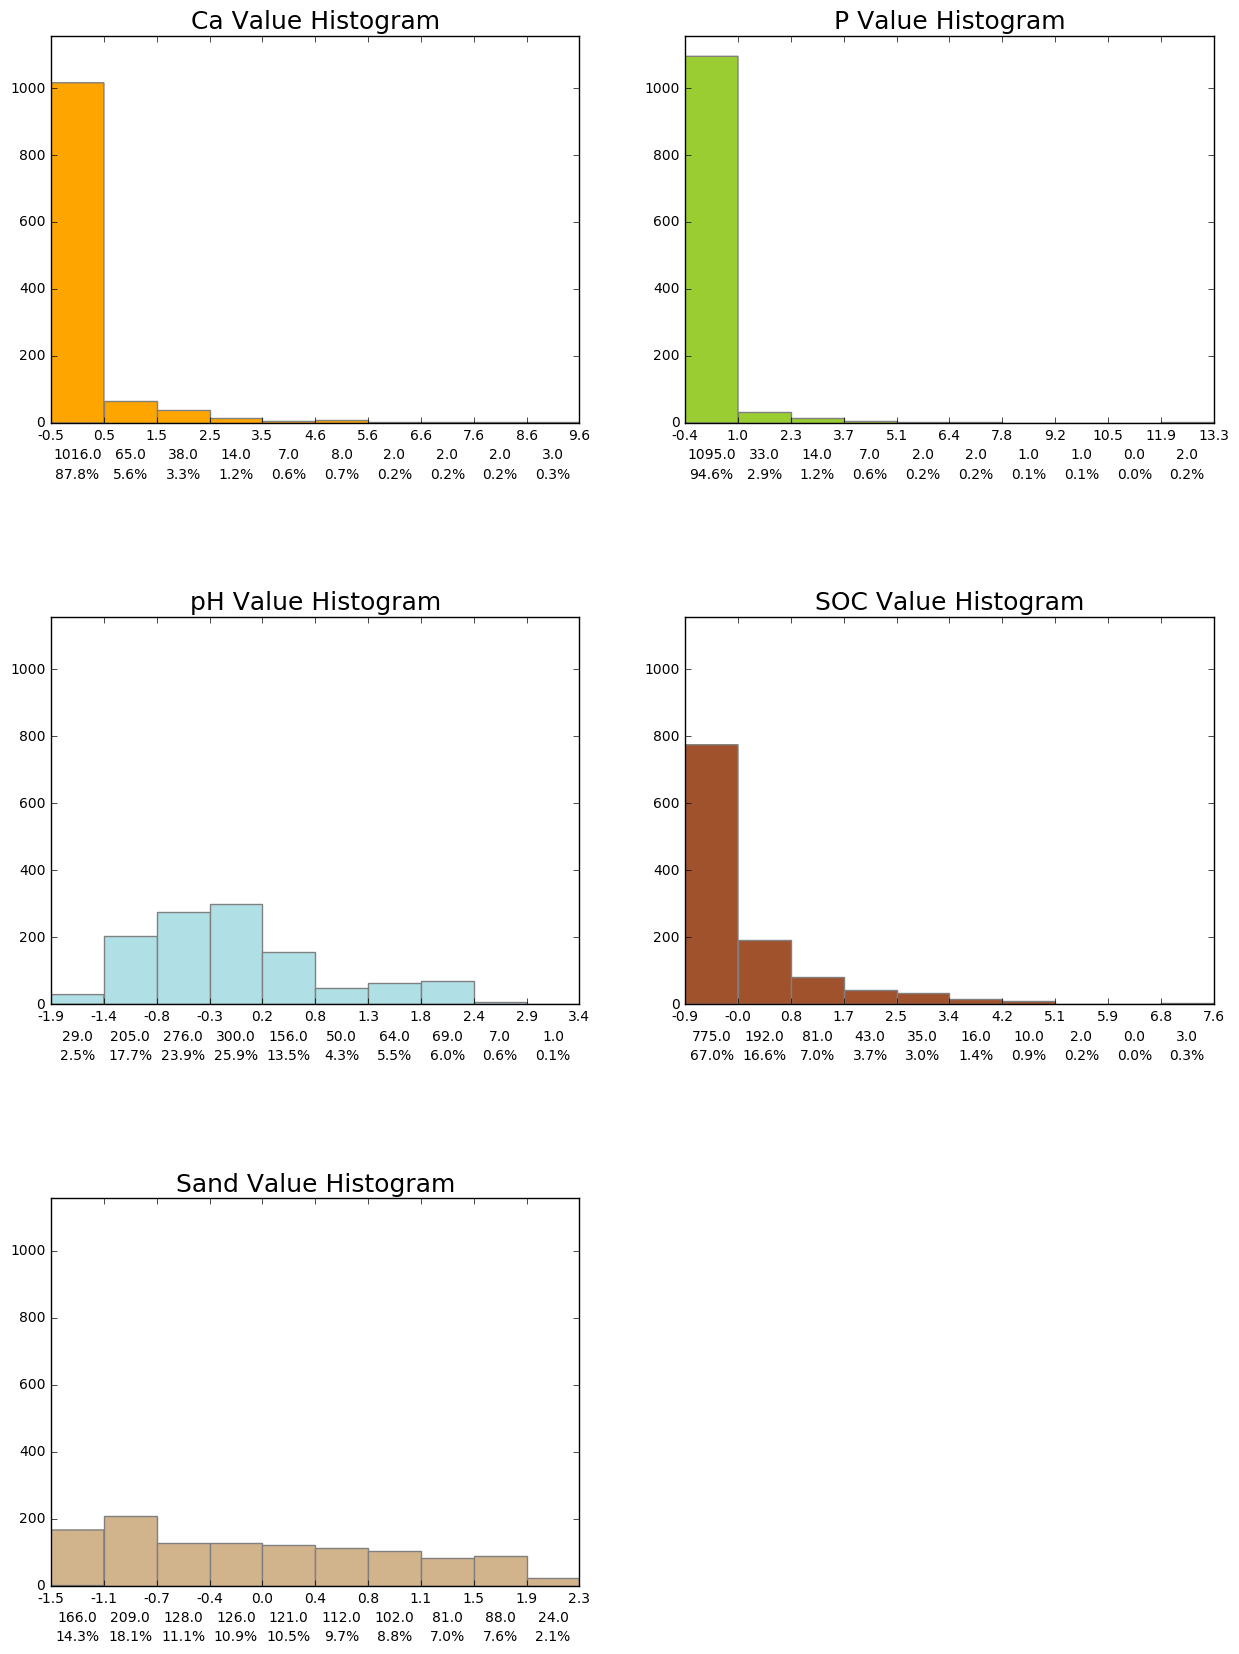

In [5]:
# Inspect the data in the five response variables

print "Ca: total = %d, max = %0.2f, mean = %0.2f, min = %0.2f" % (Ca.shape[0], np.max(Ca), np.mean(Ca), np.min(Ca))
print "P: total = %d, max = %0.2f, mean = %0.2f, min = %0.2f" % (P.shape[0], np.max(P), np.mean(P), np.min(P))
print "pH: total = %d, max = %0.2f, mean = %0.2f, min = %0.2f" % (pH.shape[0], np.max(pH), np.mean(pH), np.min(pH))
print "SOC: total = %d, max = %0.2f, mean = %0.2f, min = %0.2f" % (SOC.shape[0], np.max(SOC), np.mean(SOC), np.min(SOC))
print "Sand: total = %d, max = %0.2f, mean = %0.2f, min = %0.2f" % (Sand.shape[0], np.max(Sand), 
                                                                  np.mean(Sand), np.min(Sand))

def plot_hist(ind, data, max_y, title, color):

    counts, bins, patches = ax[ind].hist(data, facecolor=color, edgecolor='gray')
    # set the ticks to be at the edges of the bins.
    ax[ind].set_xticks(bins)
    # set the limits for x and y
    ax[ind].set_xlim([np.min(data),np.max(data)])
    ax[ind].set_ylim([0,max_y])
    # set the xaxis's tick labels to be formatted with 1 decimal place
    ax[ind].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
    ax[ind].set_title(title, fontsize=18)
  
    # Label the raw counts and the percentages below the x-axis
    bin_centers = 0.5 * np.diff(bins) + bins[:-1]
    for count, x in zip(counts, bin_centers):
        # Label the raw counts
        ax[ind].annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
            xytext=(0, -18), textcoords='offset points', va='top', ha='center')

        # Label the percentages
        percent = '%0.1f%%' % (100 * float(count) / counts.sum())
        ax[ind].annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
            xytext=(0, -32), textcoords='offset points', va='top', ha='center')


fig, ax = plt.subplots(3, 2, figsize=(15, 20))
fig.subplots_adjust(hspace = 0.5, wspace=.2)
ax = ax.ravel()

# Ca
plot_hist(0, Ca, Ca.shape[0], 'Ca Value Histogram', colors[0])
# P
plot_hist(1, P, P.shape[0], 'P Value Histogram', colors[1])
#pH
plot_hist(2, pH, pH.shape[0], 'pH Value Histogram', colors[2])
#SOC
plot_hist(3, SOC, SOC.shape[0], 'SOC Value Histogram', colors[3])
#Sand
plot_hist(4, Sand, Sand.shape[0], 'Sand Value Histogram', colors[4])
# delete the last subplot
fig.delaxes(ax[5])


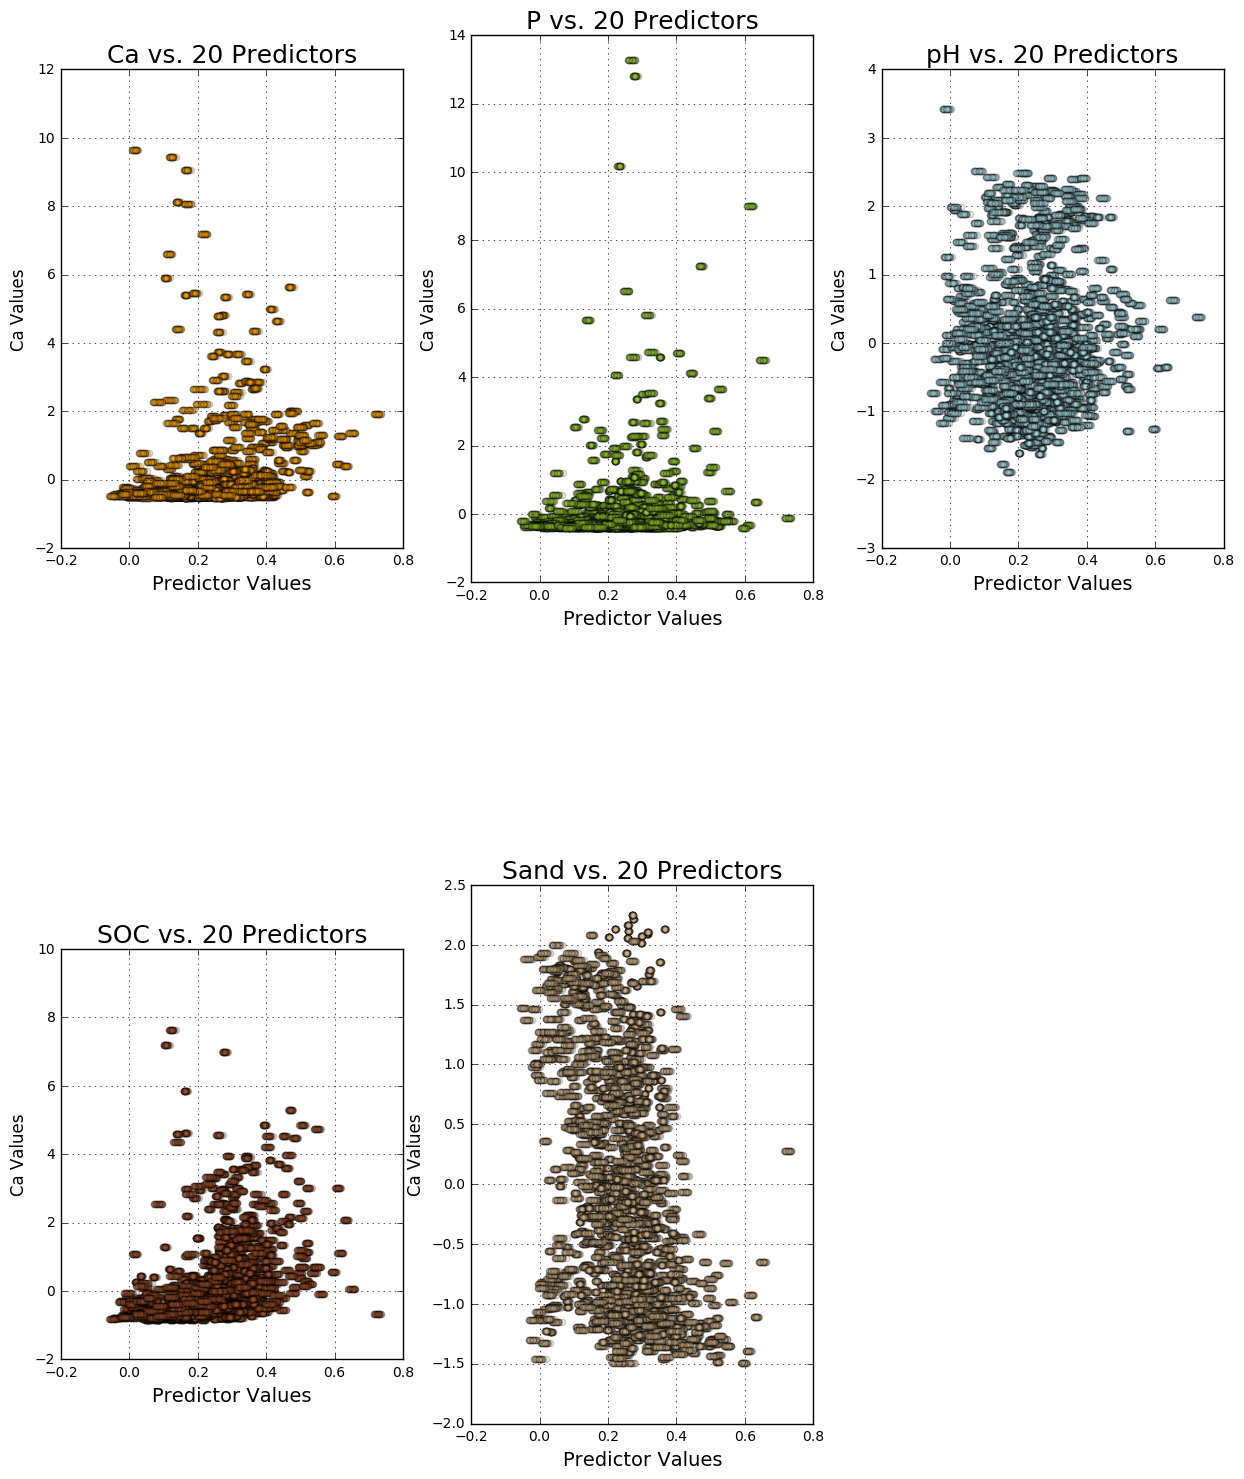

In [6]:
# Inspect the data in the predictor variables

def plot_data(ind, data_x, data_y, aspect, title, color):
    
    ax[ind].set_title(title, fontsize=18)
    ax[ind].set_xlabel('Predictor Values', fontsize=14)
    ax[ind].set_ylabel('Ca Values', fontsize=12)
    ax[ind].set_aspect(aspect = aspect, adjustable='box')
    ax[ind].grid(True)
    ax[ind].scatter(data_x, data_y, color = color, alpha = 0.2, marker = 'o', edgecolors = 'black')

# set up the grid plot
fig, ax = plt.subplots(2, 3, figsize=(15, 20))
#fig.subplots_adjust(hspace = 0.5, wspace=.2)
ax = ax.ravel()

# select the predictor range (note this is influenced by the PCA below)
my_col = 20

X_sub = np.ravel(X[:,:my_col].reshape(-1,1))

# Ca 
plot_data(0, X_sub, np.repeat(Ca, my_col), 0.1, 'Ca vs. %d Predictors' % my_col, colors[0])
# P 
plot_data(1, X_sub, np.repeat(P, my_col), 0.1, 'P vs. %d Predictors' % my_col, colors[1])
#pH 
plot_data(2, X_sub, np.repeat(pH, my_col), 0.2, 'pH vs. %d Predictors' % my_col, colors[2])
#SOC 
plot_data(3, X_sub, np.repeat(SOC, my_col), 0.1, 'SOC vs. %d Predictors' % my_col, colors[3])
#Sand 
plot_data(4, X_sub, np.repeat(Sand, my_col), 0.35, 'Sand vs. %d Predictors' % my_col, colors[4])
# delete the last subplot
fig.delaxes(ax[5])



In [215]:
# IGNORE THIS CELL - messing with np array functions

# Mess with encoding depth

le = LabelEncoder()
Depth_enc = le.fit(Depth).transform(Depth) 

print list(le.classes_)
print Depth_enc.shape
print Depth_enc.T.reshape(1,-1)
print X.shape
print Depth_enc

d = np.empty((0))
print d.shape

b = [5, 6, 7, 8, 9]
a = np.array([[1, 2, 5, 7, 10], [3, 4, 5, 22, 25]])
b = np.array(b).reshape(1,-1)
c = np.append(a, b, axis=0)
#d = np.append(d, b, axis=0)
#print d.shape
#print d

print c.shape
print c
print c[:,1]
print a.shape
print b.shape 
print np.concatenate((a, b), axis=0)

print X.shape
print Depth_enc.reshape(1,-1).shape
print np.concatenate((X, Depth_enc.reshape(1,-1).T), axis=1)[:,3592]
#all_data = np.append(X, Depth_enc, 1)

#dv = DictVectorizer(sparse=False) 
#df = pd.DataFrame(Depth).to_numeric
#dv.fit_transform(df.to_dict(orient='records'))


['Subsoil', 'Topsoil']
(1157,)
[[1 0 1 ..., 1 0 1]]
(1157, 3593)
[1 0 1 ..., 1 0 1]
(0,)
(3, 5)
[[ 1  2  5  7 10]
 [ 3  4  5 22 25]
 [ 5  6  7  8  9]]
[2 4 6]
(2, 5)
(1, 5)
[[ 1  2  5  7 10]
 [ 3  4  5 22 25]
 [ 5  6  7  8  9]]
(1157, 3593)
(1, 1157)
[ 0.0568427   0.0568427   0.0568427  ...,  1.61802173  1.61802173
  1.61802173]


In [216]:
# IGNORE THIS CELL - checking out Depth

# Depth

vals, cnts = np.unique(Depth, return_counts = True)
print vals
print cnts

# CTI
print np.where(feature_names == 'CTI')[0]
vals, cnts = np.unique(X[:,3581], return_counts = True)
#print vals
#print cnts

# ELEV
print np.where(feature_names == 'ELEV')[0]
vals, cnts = np.unique(X[:,3582], return_counts = True)
#print vals
#print cnts

# m2379.76 to m2352.76 -> CO2 fields
print np.where(feature_names == 'm237976')[0]
vals, cnts = np.unique(X[:,3582], return_counts = True)
print cnts
print np.where(feature_names == 'm235276')[0]

['Subsoil' 'Topsoil']
[576 581]
[3581]
[3582]
[2654]
[ 2  4  2  2  2  2  2  2  2  4  4  6  2  1  2  8  6  2  4  4  4  2  6  4  8
  6  6  2  4  4  8  2  2  2 10  2  2  2  2  2  2  2  2  4  3  4  2  4  4  2
  4  2  2  6  2  2  2  2  4  2  2  2  4  4  4  4  6  2  8  4  4  6  4  2  2
  2  2  2  4  2  2  2  2  2  2  2  2  2  2  4  2  2  4  4  2  4  2  2  2  6
  6  2  2 10  2  4  2  2  6  4  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  6  1
  4  2  2  4  2  4  2  2  2  2  2  2  2  2  2  4  4  4  2  2  2  4  2  4  2
  6  6  6  8  6  2  2  2  2  2  4  2  2  2  2  4  2  2  2  2  2  2  2  2  2
  2  2  4  2  3  8  4  2  2  4  2  2  6  4  8  8  2  4  4  2  2  4  2  2  4
  2  4  4  2  2  2  2  2  2  2  2  2  2  2  2  6  2  6  2  4  3  4  2  2  2
  2  2  2  4  2  1  2  4  2  2  4  2  8  4  6  2  6  2  2  6  6  2  4  4  2
  2  2  2  2  2  2  2  2  2  2  4  2  1  2  4  1  4  2  4  2  2  4  2  6  2
  2  4  4  4  2  6  2  4  2  6  2  

**Which features have more impact?**

There are over three thousand features in this data, with few rows. Thus, we have a large k but small n data set to work with. Perhaps there is a subset of features to focus on.

Below, we investigate two variations of PCA to explain variances over the features. We observe that the first 20 components explain increasing portions of the variance, however after 20 components, the subsequent ones don't really help. The first 70-80 features will explain ~100% of the variance.


-------------------------------------------
Fraction of the total variance in the training explained by first k components: 

1 	 70.54% 	 66.91% 	 m749796
2 	 79.38% 	 75.72% 	 m749604
3 	 85.54% 	 82.10% 	 m749411
4 	 89.31% 	 85.88% 	 m749218
5 	 91.69% 	 88.83% 	 m749025
6 	 93.63% 	 90.85% 	 m748832
7 	 95.14% 	 92.57% 	 m748639
8 	 96.16% 	 94.10% 	 m748446
9 	 96.75% 	 95.11% 	 m748254
10 	 97.27% 	 95.74% 	 m748061
11 	 97.74% 	 96.29% 	 m747868
12 	 98.10% 	 96.76% 	 m747675
13 	 98.42% 	 97.14% 	 m747482
14 	 98.69% 	 97.49% 	 m747289
15 	 98.90% 	 97.77% 	 m747097
16 	 99.06% 	 98.00% 	 m746904
17 	 99.20% 	 98.21% 	 m746711
18 	 99.34% 	 98.40% 	 m746518
19 	 99.44% 	 98.55% 	 m746325
20 	 99.50% 	 98.69% 	 m746132
21 	 99.56% 	 98.80% 	 m745939
22 	 99.62% 	 98.90% 	 m745747
23 	 99.67% 	 98.99% 	 m745554
24 	 99.72% 	 99.07% 	 m745361
25 	 99.75% 	 99.14% 	 m745168
26 	 99.78% 	 99.20% 	 m744975
27 	 99.81% 	 99.26% 	 m744782
28 	 99.83% 	 99.31% 	 m744589
29 	 99.85% 	 

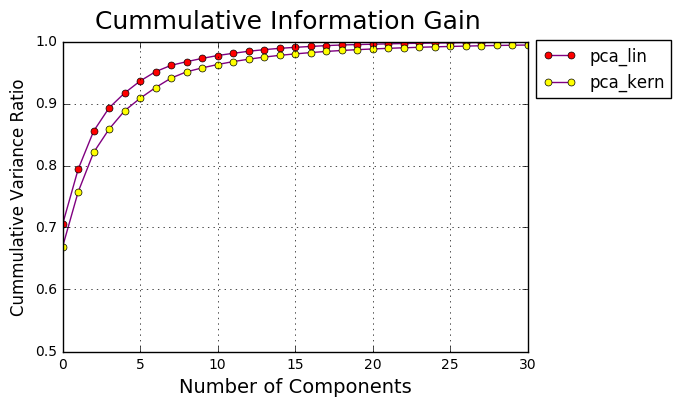

In [175]:
# Linear PCA using all of the features
n_comp = feature_names.shape[0]
pca_lin = PCA(n_components = n_comp)
pca_lin.fit(X)
pca_lin_cumsum = np.cumsum(pca_lin.explained_variance_ratio_)

# Non-linear kernel RBF PCA using all of the features 
pca_kern = KernelPCA(n_components = n_comp, kernel = 'rbf')
pca_kern.fit(X)

# build the explained variance ratio list for pca_kern
explained_var_ratio_kern = []
for i in range(0, pca_kern.lambdas_.shape[0]):
    explained_var_ratio_kern.append(pca_kern.lambdas_[i]/sum(pca_kern.lambdas_))
pca_kern_cumsum = np.cumsum(np.asarray(explained_var_ratio_kern))

# Plot the Information Gain graph
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(pca_lin_cumsum, color = 'purple', marker = 'o', ms = 5, mfc = 'red', label = 'pca_lin')
ax.plot(pca_kern_cumsum, color = 'purple', marker = 'o', ms = 5, mfc = 'yellow', label = 'pca_kern')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.91), shadow=False, scatterpoints=1)
fig.suptitle('Cummulative Information Gain', fontsize=18)
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Cummulative Variance Ratio', fontsize=12)
plt.grid(True)
ax.set_xlim([0,30])
ax.set_ylim([0.5,1.0])

# Output variance fractions
print '\n-------------------------------------------'
print 'Fraction of the total variance in the training explained by first k components: \n'
for k in range(1,76): 
    print("%d \t %s \t %s \t %s" % (k, '{0:.2f}%'.format(pca_lin_cumsum[k-1] * 100), 
                                    '{0:.2f}%'.format(pca_kern_cumsum[k-1] * 100), feature_names[k-1]))

**MODELING WORK ZONE BELOW**

In [169]:
# Set up list of pipelines and MSE scores

y_vars_pipelines = []
y_vars_scores = []

In [171]:
# Linear Regression with PCA combinations

y_pipelines = []
y_scores = []

for ind, y in enumerate(y_vars):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    # set up the train and test data
    print '\n----------', y_var_labels[ind]

    pca = PCA()
    linear = LinearRegression()
    steps = [('pca', pca), ('linear', linear)]
    pipeline = Pipeline(steps)

    parameters = dict(pca__n_components=list(range(20, 90, 10)))

    cv = GridSearchCV(pipeline, param_grid=parameters, verbose=0)
    cv.fit(X_train, y_train)   

    print 'Cross_val_score: ', cross_val_score(cv, X_test, y_test)
    
    y_predictions = cv.predict(X_test)
    mse = mean_squared_error(y_test, y_predictions)
    print 'Explained variance score: ', explained_variance_score(y_test, y_predictions)
    print 'Mean absolute error: ', mean_absolute_error(y_test, y_predictions)
    print 'Mean squared error: ', mse
    print 'R2 score: ', r2_score(y_test, y_predictions)
    
    display(pd.DataFrame.from_dict(cv.cv_results_))
    
    # capture the best pipeline estimator and mse value
    y_pipelines.append(cv.best_estimator_)
    y_scores.append(mse)
    
y_vars_pipelines.append(y_pipelines)
y_vars_scores.append(y_scores)



---------- Ca
Cross_val_score:  [ 0.85731465  0.64204299  0.82727406]
Explained variance score:  0.902932346434
Mean absolute error:  0.189894422632
Mean squared error:  0.165567522997
R2 score:  0.902874994727


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_pca__n_components,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.393394,0.016072,0.754095,0.828380,20,{u'pca__n_components': 20},7,0.786492,0.823218,0.734915,0.839288,0.740753,0.822633,0.057214,0.001901,0.023076,0.007717
1,0.321090,0.022429,0.813438,0.890428,30,{u'pca__n_components': 30},6,0.856918,0.870219,0.778788,0.924596,0.804440,0.876470,0.026785,0.009638,0.032534,0.024295
2,0.380198,0.016413,0.842704,0.915307,40,{u'pca__n_components': 40},4,0.898521,0.903702,0.778255,0.935067,0.851119,0.907152,0.011763,0.000382,0.049473,0.014043
3,0.388798,0.024829,0.852990,0.921654,50,{u'pca__n_components': 50},1,0.904858,0.914135,0.799095,0.939175,0.854815,0.911651,0.011274,0.010334,0.043210,0.012431
4,0.392187,0.020583,0.848958,0.926469,60,{u'pca__n_components': 60},2,0.900721,0.920386,0.803080,0.941670,0.842873,0.917349,0.077155,0.000334,0.040105,0.010820
5,0.370175,0.022387,0.842832,0.935134,70,{u'pca__n_components': 70},3,0.901530,0.928827,0.795664,0.944701,0.831074,0.931875,0.038309,0.002798,0.044024,0.006878
6,0.443257,0.023019,0.842310,0.941391,80,{u'pca__n_components': 80},5,0.904538,0.937151,0.778272,0.949690,0.843878,0.937333,0.019360,0.000219,0.051576,0.005869



---------- P
Cross_val_score:  [ 0.17665964 -0.03694202  0.06631575]
Explained variance score:  0.0881770992851
Mean absolute error:  0.533738566291
Mean squared error:  1.10791165952
R2 score:  0.087998170557


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_pca__n_components,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.402010,0.025025,-0.041603,0.113635,20,{u'pca__n_components': 20},2,0.018882,0.134501,0.044382,0.086648,-0.188307,0.119755,0.056958,0.009341,0.104157,0.020009
1,0.575636,0.027383,-0.079192,0.147394,30,{u'pca__n_components': 30},3,0.013584,0.181934,0.050265,0.103973,-0.301785,0.156276,0.070312,0.003707,0.157957,0.032441
2,0.557240,0.026235,-0.109349,0.178606,40,{u'pca__n_components': 40},5,0.019636,0.198604,0.035033,0.143186,-0.383217,0.194030,0.125600,0.005336,0.193568,0.025116
3,0.701564,0.023060,-0.123939,0.251137,50,{u'pca__n_components': 50},7,0.006675,0.292889,0.053297,0.202143,-0.432295,0.258380,0.040924,0.005163,0.218661,0.037399
4,0.454254,0.055771,-0.097910,0.294392,60,{u'pca__n_components': 60},4,-0.011428,0.337582,0.053666,0.252187,-0.336304,0.293408,0.022929,0.025737,0.170491,0.034870
5,0.514572,0.034006,-0.025718,0.352387,70,{u'pca__n_components': 70},1,0.062399,0.396933,0.169168,0.298362,-0.309061,0.361865,0.061187,0.002861,0.204854,0.040796
6,0.561735,0.026532,-0.114613,0.413849,80,{u'pca__n_components': 80},6,0.041939,0.461141,0.086725,0.372069,-0.473110,0.408337,0.112171,0.001816,0.253910,0.036572



---------- pH
Cross_val_score:  [ 0.73084859  0.75236432  0.77384693]
Explained variance score:  0.801303361036
Mean absolute error:  0.299955807022
Mean squared error:  0.175557711994
R2 score:  0.800652729256


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_pca__n_components,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.416794,0.020709,0.691089,0.722522,20,{u'pca__n_components': 20},7,0.652554,0.736104,0.715580,0.712145,0.705282,0.719316,0.072196,0.004896,0.027622,0.010040
1,0.325088,0.016399,0.746369,0.790605,30,{u'pca__n_components': 30},6,0.734625,0.797822,0.743252,0.787928,0.761277,0.786066,0.004867,0.000649,0.011104,0.005159
2,0.394604,0.017684,0.758659,0.809747,40,{u'pca__n_components': 40},5,0.747592,0.815125,0.755233,0.809337,0.773196,0.804779,0.016796,0.001957,0.010733,0.004234
3,0.413428,0.021939,0.760762,0.823252,50,{u'pca__n_components': 50},4,0.752305,0.825534,0.774077,0.817078,0.755937,0.827144,0.008391,0.005625,0.009522,0.004415
4,0.351497,0.020889,0.764751,0.839916,60,{u'pca__n_components': 60},3,0.746958,0.848279,0.785540,0.833833,0.761825,0.837637,0.014539,0.001944,0.015891,0.006114
5,0.382889,0.023518,0.769305,0.847817,70,{u'pca__n_components': 70},2,0.754525,0.860323,0.787135,0.838982,0.766313,0.844145,0.041701,0.004405,0.013484,0.009091
6,0.437125,0.025332,0.791313,0.867404,80,{u'pca__n_components': 80},1,0.782388,0.875469,0.812292,0.854681,0.779293,0.872063,0.018186,0.003124,0.014874,0.009104



---------- SOC
Cross_val_score:  [ 0.90782929  0.89955839  0.87414596]
Explained variance score:  0.898510067408
Mean absolute error:  0.256893429576
Mean squared error:  0.154519194409
R2 score:  0.897504874278


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_pca__n_components,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.399214,0.017472,0.797619,0.819385,20,{u'pca__n_components': 20},7,0.822033,0.816291,0.787956,0.819209,0.782772,0.822655,0.078175,0.003413,0.017426,0.002601
1,0.428866,0.018041,0.828866,0.849898,30,{u'pca__n_components': 30},6,0.837594,0.845908,0.828337,0.849924,0.820634,0.853861,0.094644,0.002638,0.006936,0.003247
2,0.609206,0.025858,0.834045,0.862557,40,{u'pca__n_components': 40},5,0.840483,0.858302,0.838127,0.862340,0.823499,0.867031,0.115477,0.003842,0.007511,0.003567
3,0.476467,0.024161,0.846777,0.887900,50,{u'pca__n_components': 50},4,0.850535,0.885021,0.858049,0.887763,0.831734,0.890917,0.036286,0.005816,0.011061,0.002409
4,0.352480,0.022441,0.868609,0.905778,60,{u'pca__n_components': 60},3,0.878687,0.901500,0.870291,0.906233,0.856811,0.909600,0.014712,0.003176,0.009013,0.003322
5,0.355462,0.020531,0.872025,0.922173,70,{u'pca__n_components': 70},2,0.890462,0.915696,0.876525,0.929882,0.849016,0.920940,0.004012,0.000360,0.017222,0.005857
6,0.420788,0.026892,0.879037,0.930817,80,{u'pca__n_components': 80},1,0.893266,0.925249,0.873082,0.938770,0.870709,0.928431,0.016154,0.005922,0.010127,0.005772



---------- Sand
Cross_val_score:  [ 0.86440679  0.82708485  0.84930448]
Explained variance score:  0.887127196825
Mean absolute error:  0.236842447774
Mean squared error:  0.111438502427
R2 score:  0.886948580476


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_pca__n_components,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.551976,0.020786,0.722476,0.753399,20,{u'pca__n_components': 20},7,0.713686,0.768845,0.726062,0.749875,0.727714,0.741479,0.079372,0.002418,0.006264,0.011447
1,0.736551,0.030037,0.780063,0.824485,30,{u'pca__n_components': 30},6,0.782817,0.829377,0.744068,0.827580,0.813295,0.816497,0.063050,0.001963,0.028311,0.005696
2,1.061777,0.040536,0.804505,0.853153,40,{u'pca__n_components': 40},5,0.791192,0.862613,0.784519,0.859301,0.837855,0.837545,0.107004,0.000670,0.023716,0.011119
3,1.228928,0.048335,0.820066,0.871825,50,{u'pca__n_components': 50},4,0.812076,0.874861,0.803364,0.877251,0.844790,0.863362,0.087466,0.021253,0.017824,0.006063
4,0.654686,0.024945,0.823728,0.881754,60,{u'pca__n_components': 60},3,0.823413,0.883968,0.797730,0.888326,0.850041,0.872968,0.100979,0.001626,0.021343,0.006462
5,0.528567,0.032249,0.834453,0.889560,70,{u'pca__n_components': 70},2,0.831371,0.890163,0.804758,0.899602,0.867242,0.878915,0.106824,0.009937,0.025586,0.008456
6,0.594875,0.032863,0.846494,0.896627,80,{u'pca__n_components': 80},1,0.853944,0.896824,0.817838,0.905203,0.867672,0.887853,0.104969,0.009576,0.021005,0.007085


In [177]:
#CONSIDER HOW TO CHOOSE FEATURES FOR EACH RESPONSE VAR

# Linear Regression with PCA and SelectKBest

y_pipelines = []
y_scores = []

for ind, y in enumerate(y_vars):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    # set up the train and test data
    print '\n----------', y_var_labels[ind]

    pca = PCA(n_components=2)
    selection = SelectKBest(k=1)
    combined_features = FeatureUnion([('pca', pca), ('univ_select', selection)])
    linear = LinearRegression()
    
    steps = [('features', combined_features), ('linear', linear)]
    pipeline = Pipeline(steps)

    parameters = dict(features__pca__n_components=list(range(20, 90, 10)),
                  features__univ_select__k=[1, 2, 3])

    cv = GridSearchCV(pipeline, param_grid=parameters, verbose=0)
    cv.fit(X_train, y_train)   

    print 'Cross_val_score: ', cross_val_score(cv, X_test, y_test)
    
    y_predictions = cv.predict(X_test)
    mse = mean_squared_error(y_test, y_predictions)
    print 'Explained variance score: ', explained_variance_score(y_test, y_predictions)
    print 'Mean absolute error: ', mean_absolute_error(y_test, y_predictions)
    print 'Mean squared error: ', mse
    print 'R2 score: ', r2_score(y_test, y_predictions)
    
    display(pd.DataFrame.from_dict(cv.cv_results_))
    
    # capture the best pipeline estimator and mse value
    y_pipelines.append(cv.best_estimator_)
    y_scores.append(mse)
    
y_vars_pipelines.append(y_pipelines)
y_vars_scores.append(y_scores)


---------- Ca
Cross_val_score:  [ 0.85101659  0.61272391  0.84562684]
Explained variance score:  0.902699925906
Mean absolute error:  0.190839804095
Mean squared error:  0.166036106089
R2 score:  0.902600115122


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_features__pca__n_components,param_features__univ_select__k,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.586311,0.020695,0.769369,0.841688,20,1,"{u'features__pca__n_components': 20, u'feature...",21,0.832821,0.855224,0.742360,0.840527,0.732681,0.829311,0.171562,0.002012,0.045127,0.010611
1,0.427322,0.019516,0.774451,0.850779,20,2,"{u'features__pca__n_components': 20, u'feature...",20,0.835924,0.858197,0.743667,0.851830,0.743522,0.842309,0.005095,0.001757,0.043553,0.006529
2,0.415155,0.019458,0.774557,0.853921,20,3,"{u'features__pca__n_components': 20, u'feature...",19,0.848586,0.863273,0.737449,0.853896,0.737348,0.844594,0.005368,0.000722,0.052448,0.007626
3,0.436729,0.021324,0.821821,0.895495,30,1,"{u'features__pca__n_components': 30, u'feature...",18,0.878299,0.876526,0.771517,0.928763,0.815429,0.881198,0.007045,0.001710,0.043841,0.023601
4,0.430745,0.020810,0.823500,0.897139,30,2,"{u'features__pca__n_components': 30, u'feature...",17,0.875198,0.877886,0.775268,0.931554,0.819834,0.881976,0.013987,0.001884,0.040891,0.024392
5,0.451732,0.019346,0.824200,0.898120,30,3,"{u'features__pca__n_components': 30, u'feature...",16,0.878549,0.879217,0.774005,0.931663,0.819837,0.883481,0.013140,0.000157,0.042804,0.023782
6,0.511921,0.021186,0.844664,0.916155,40,1,"{u'features__pca__n_components': 40, u'feature...",6,0.903164,0.905176,0.778197,0.935069,0.852403,0.908219,0.019570,0.001110,0.051326,0.013432
7,0.531197,0.020444,0.842539,0.916390,40,2,"{u'features__pca__n_components': 40, u'feature...",8,0.900487,0.905473,0.778179,0.935082,0.848727,0.908613,0.046967,0.000154,0.050139,0.013280
8,0.519091,0.021819,0.841409,0.916677,40,3,"{u'features__pca__n_components': 40, u'feature...",9,0.901856,0.905592,0.778650,0.935311,0.843486,0.909129,0.015604,0.000760,0.050336,0.013255
9,0.544905,0.022121,0.852977,0.922137,50,1,"{u'features__pca__n_components': 50, u'feature...",1,0.904453,0.915355,0.799211,0.939377,0.855068,0.911679,0.009366,0.000134,0.043004,0.012283



---------- P
Cross_val_score:  [ 0.17170426 -0.01946386  0.066096  ]
Explained variance score:  0.0951485295355
Mean absolute error:  0.534154904351
Mean squared error:  1.09944255316
R2 score:  0.0949697015751


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_features__pca__n_components,param_features__univ_select__k,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.529920,0.022470,-0.045685,0.114748,20,1,"{u'features__pca__n_components': 20, u'feature...",4,0.020140,0.134721,0.048709,0.087105,-0.206158,0.122419,0.163856,0.001876,0.113961,0.020181
1,0.416035,0.021035,-0.086358,0.126881,20,2,"{u'features__pca__n_components': 20, u'feature...",8,0.021627,0.135365,0.052264,0.091503,-0.333383,0.153774,0.019200,0.001860,0.174952,0.026120
2,0.397940,0.020573,-0.094001,0.128104,20,3,"{u'features__pca__n_components': 20, u'feature...",11,0.016801,0.138448,0.056548,0.091731,-0.355782,0.154133,0.006552,0.000937,0.185639,0.026505
3,0.419542,0.021756,-0.083077,0.150416,30,1,"{u'features__pca__n_components': 30, u'feature...",6,0.005631,0.187237,0.042132,0.104885,-0.297337,0.159125,0.008752,0.000414,0.152090,0.034180
4,0.413705,0.024570,-0.092832,0.158477,30,2,"{u'features__pca__n_components': 30, u'feature...",10,0.013760,0.191400,0.040453,0.109605,-0.333123,0.174425,0.019654,0.004010,0.170097,0.035246
5,0.410668,0.021613,-0.116746,0.160838,30,3,"{u'features__pca__n_components': 30, u'feature...",13,0.007710,0.195097,0.046664,0.110542,-0.405096,0.176875,0.012774,0.000250,0.204317,0.036334
6,0.484571,0.023077,-0.104790,0.186769,40,1,"{u'features__pca__n_components': 40, u'feature...",12,0.005291,0.212662,0.040505,0.151805,-0.360592,0.195840,0.008384,0.000777,0.181276,0.025660
7,0.493295,0.023969,-0.136970,0.198384,40,2,"{u'features__pca__n_components': 40, u'feature...",15,0.006439,0.214904,0.017380,0.163906,-0.435285,0.216342,0.013871,0.001012,0.210784,0.024387
8,0.480983,0.024093,-0.159749,0.199821,40,3,"{u'features__pca__n_components': 40, u'feature...",18,-0.001096,0.217690,0.020851,0.164553,-0.499618,0.217222,0.008857,0.002160,0.240258,0.024939
9,0.510079,0.025075,-0.128163,0.252279,50,1,"{u'features__pca__n_components': 50, u'feature...",14,0.010552,0.293586,0.053537,0.202531,-0.449116,0.260719,0.015440,0.000365,0.227407,0.037649



---------- pH
Cross_val_score:  [ 0.73693918  0.7367523   0.77926092]
Explained variance score:  0.79835930949
Mean absolute error:  0.303006573751
Mean squared error:  0.177842748189
R2 score:  0.798058051279


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_features__pca__n_components,param_features__univ_select__k,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.497542,0.021377,0.691031,0.723218,20,1,"{u'features__pca__n_components': 20, u'feature...",19,0.652165,0.736139,0.714879,0.713900,0.706200,0.719615,0.053557,0.001035,0.027762,0.009430
1,0.503651,0.028604,0.689878,0.723979,20,2,"{u'features__pca__n_components': 20, u'feature...",20,0.650603,0.736307,0.714398,0.713932,0.704786,0.721696,0.070234,0.003641,0.028100,0.009276
2,0.651919,0.041307,0.689128,0.729231,20,3,"{u'features__pca__n_components': 20, u'feature...",21,0.630619,0.741642,0.716620,0.715734,0.720372,0.730317,0.114469,0.001779,0.041481,0.010605
3,0.481817,0.022349,0.744542,0.791754,30,1,"{u'features__pca__n_components': 30, u'feature...",17,0.734084,0.799758,0.742401,0.787967,0.757181,0.787537,0.069853,0.000750,0.009553,0.005662
4,0.474622,0.031313,0.743608,0.793906,30,2,"{u'features__pca__n_components': 30, u'feature...",18,0.731366,0.802520,0.745534,0.788446,0.753972,0.790751,0.029409,0.008185,0.009331,0.006164
5,0.458399,0.022639,0.745767,0.795871,30,3,"{u'features__pca__n_components': 30, u'feature...",16,0.727156,0.803175,0.745598,0.788476,0.764619,0.795961,0.004208,0.000312,0.015299,0.006001
6,0.556194,0.028457,0.755266,0.810433,40,1,"{u'features__pca__n_components': 40, u'feature...",11,0.745516,0.815343,0.747884,0.811078,0.772437,0.804878,0.029107,0.002432,0.012168,0.004296
7,0.630874,0.028841,0.754017,0.812895,40,2,"{u'features__pca__n_components': 40, u'feature...",12,0.741511,0.817873,0.750040,0.812125,0.770548,0.808686,0.095090,0.003544,0.012186,0.003790
8,0.610956,0.025442,0.753606,0.815028,40,3,"{u'features__pca__n_components': 40, u'feature...",14,0.739152,0.819208,0.743218,0.814437,0.778505,0.811439,0.110153,0.001929,0.017667,0.003199
9,0.587681,0.034560,0.753680,0.825836,50,1,"{u'features__pca__n_components': 50, u'feature...",13,0.751185,0.826236,0.755585,0.823692,0.754281,0.827582,0.011868,0.008577,0.001846,0.001613



---------- SOC
Cross_val_score:  [ 0.89690555  0.90089167  0.86365898]
Explained variance score:  0.89881634149
Mean absolute error:  0.256838236234
Mean squared error:  0.154074727828
R2 score:  0.897799696279


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_features__pca__n_components,param_features__univ_select__k,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.508114,0.023841,0.800592,0.820377,20,1,"{u'features__pca__n_components': 20, u'feature...",21,0.823512,0.816552,0.788352,0.819265,0.789821,0.825313,0.050906,0.001665,0.016250,0.003662
1,0.457097,0.021494,0.803949,0.822743,20,2,"{u'features__pca__n_components': 20, u'feature...",19,0.826719,0.819276,0.788381,0.819269,0.796660,0.829684,0.023838,0.000593,0.016482,0.004908
2,0.524004,0.028352,0.802505,0.829611,20,3,"{u'features__pca__n_components': 20, u'feature...",20,0.831080,0.825249,0.794243,0.824295,0.782080,0.839291,0.060605,0.009930,0.020844,0.006856
3,0.459057,0.027344,0.828556,0.850595,30,1,"{u'features__pca__n_components': 30, u'feature...",18,0.836913,0.846753,0.828606,0.850693,0.820115,0.854339,0.044662,0.002983,0.006860,0.003098
4,0.434652,0.022841,0.834780,0.855087,30,2,"{u'features__pca__n_components': 30, u'feature...",14,0.854122,0.857675,0.829754,0.852251,0.820388,0.855335,0.012295,0.000543,0.014226,0.002221
5,0.466098,0.027689,0.832045,0.859782,30,3,"{u'features__pca__n_components': 30, u'feature...",17,0.857890,0.858478,0.833574,0.853850,0.804571,0.867018,0.012802,0.004511,0.021801,0.005454
6,0.546504,0.024397,0.834260,0.862977,40,1,"{u'features__pca__n_components': 40, u'feature...",16,0.840929,0.858356,0.839359,0.863406,0.822465,0.867168,0.004219,0.001651,0.008357,0.003610
7,0.544524,0.028227,0.837081,0.865305,40,2,"{u'features__pca__n_components': 40, u'feature...",13,0.851575,0.863311,0.838131,0.864370,0.821480,0.868234,0.023602,0.004415,0.012313,0.002116
8,0.570665,0.028011,0.834701,0.871252,40,3,"{u'features__pca__n_components': 40, u'feature...",15,0.854661,0.863608,0.848897,0.869559,0.800468,0.880589,0.060407,0.004959,0.024297,0.007035
9,0.681130,0.031615,0.847861,0.889257,50,1,"{u'features__pca__n_components': 50, u'feature...",11,0.852944,0.887699,0.858281,0.888161,0.832338,0.891912,0.155880,0.004889,0.011180,0.001887



---------- Sand
Cross_val_score:  [ 0.84717647  0.800494    0.86766102]
Explained variance score:  0.892338475087
Mean absolute error:  0.234085608966
Mean squared error:  0.106376628818
R2 score:  0.892083717655


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_features__pca__n_components,param_features__univ_select__k,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.512817,0.022956,0.728875,0.758051,20,1,"{u'features__pca__n_components': 20, u'feature...",21,0.713348,0.768853,0.736234,0.751876,0.737104,0.753425,0.048459,0.003245,0.011006,0.007664
1,0.433742,0.021041,0.734173,0.763877,20,2,"{u'features__pca__n_components': 20, u'feature...",20,0.711119,0.769942,0.738468,0.759854,0.753021,0.761836,0.010324,0.003796,0.017379,0.004364
2,0.447651,0.019951,0.762917,0.779734,20,3,"{u'features__pca__n_components': 20, u'feature...",19,0.717073,0.772011,0.764114,0.779056,0.807743,0.788135,0.018081,0.001158,0.037037,0.006600
3,0.475403,0.029474,0.783026,0.825243,30,1,"{u'features__pca__n_components': 30, u'feature...",18,0.782822,0.829380,0.750820,0.829188,0.815438,0.817162,0.002157,0.010963,0.026363,0.005715
4,0.490282,0.024601,0.787514,0.829076,30,2,"{u'features__pca__n_components': 30, u'feature...",17,0.780529,0.829986,0.755750,0.831261,0.826289,0.825981,0.040416,0.003557,0.029201,0.002250
5,0.459517,0.022500,0.796610,0.833031,30,3,"{u'features__pca__n_components': 30, u'feature...",16,0.780155,0.830044,0.768202,0.838267,0.841537,0.830783,0.021445,0.000237,0.032111,0.003715
6,0.528848,0.027786,0.804524,0.856352,40,1,"{u'features__pca__n_components': 40, u'feature...",15,0.794428,0.865586,0.784059,0.860544,0.835125,0.842925,0.027252,0.006117,0.022028,0.009714
7,0.526939,0.021685,0.806645,0.860048,40,2,"{u'features__pca__n_components': 40, u'feature...",14,0.795075,0.865655,0.784001,0.860557,0.840904,0.853932,0.000804,0.001452,0.024620,0.004799
8,0.545784,0.026433,0.811228,0.861919,40,3,"{u'features__pca__n_components': 40, u'feature...",13,0.795077,0.865673,0.787730,0.863905,0.850938,0.856180,0.050491,0.003837,0.028212,0.004122
9,0.571142,0.023079,0.821522,0.874377,50,1,"{u'features__pca__n_components': 50, u'feature...",12,0.817086,0.876728,0.798446,0.880041,0.849053,0.866362,0.046186,0.000267,0.020885,0.005827


In [179]:
# Ridge Regression with PCA combinations

y_pipelines = []
y_scores = []

for ind, y in enumerate(y_vars):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    # set up the train and test data
    print '\n----------', y_var_labels[ind]

    pca = PCA()
    ridge = Ridge()
    steps = [('pca', pca), ('ridge', ridge)]
    pipeline = Pipeline(steps)

    parameters = dict(pca__n_components=list(range(20, 90, 10)),
                     ridge__alpha=np.linspace(0.0, 0.5, 5))

    cv = GridSearchCV(pipeline, param_grid=parameters, verbose=0)
    cv.fit(X_train, y_train)   

    print 'Cross_val_score: ', cross_val_score(cv, X_test, y_test)
    
    y_predictions = cv.predict(X_test)
    mse = mean_squared_error(y_test, y_predictions)
    print 'Explained variance score: ', explained_variance_score(y_test, y_predictions)
    print 'Mean absolute error: ', mean_absolute_error(y_test, y_predictions)
    print 'Mean squared error: ', mse
    print 'R2 score: ', r2_score(y_test, y_predictions)
    
    display(pd.DataFrame.from_dict(cv.cv_results_))
    
    # capture the best pipeline estimator and mse value
    y_pipelines.append(cv.best_estimator_)
    y_scores.append(mse)
    
y_vars_pipelines.append(y_pipelines)
y_vars_scores.append(y_scores)


---------- Ca
Cross_val_score:  [ 0.86944373  0.69738114  0.87126671]
Explained variance score:  0.897270014247
Mean absolute error:  0.19137816629
Mean squared error:  0.175218170382
R2 score:  0.897213744494


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_pca__n_components,param_ridge__alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.514769,0.021318,0.754095,0.828380,20,0,"{u'ridge__alpha': 0.0, u'pca__n_components': 20}",35,0.786492,0.823218,0.734915,0.839288,0.740753,0.822633,0.225342,0.006104,0.023076,0.007717
1,0.301206,0.015001,0.754172,0.828379,20,0.125,"{u'ridge__alpha': 0.125, u'pca__n_components':...",34,0.786758,0.823218,0.735033,0.839287,0.740600,0.822632,0.019840,0.000828,0.023197,0.007717
2,0.281299,0.014528,0.754249,0.828378,20,0.25,"{u'ridge__alpha': 0.25, u'pca__n_components': 20}",33,0.787022,0.823217,0.735151,0.839286,0.740446,0.822631,0.003759,0.000193,0.023319,0.007717
3,0.304163,0.014552,0.754324,0.828377,20,0.375,"{u'ridge__alpha': 0.375, u'pca__n_components':...",32,0.787284,0.823215,0.735267,0.839284,0.740293,0.822630,0.021686,0.000340,0.023441,0.007717
4,0.436415,0.020406,0.754398,0.828374,20,0.5,"{u'ridge__alpha': 0.5, u'pca__n_components': 20}",31,0.787545,0.823213,0.735382,0.839282,0.740140,0.822628,0.107993,0.003529,0.023563,0.007717
5,0.421519,0.015660,0.813438,0.890428,30,0,"{u'ridge__alpha': 0.0, u'pca__n_components': 30}",30,0.856918,0.870219,0.778788,0.924596,0.804440,0.876470,0.068283,0.000390,0.032534,0.024295
6,0.372958,0.018341,0.813705,0.890422,30,0.125,"{u'ridge__alpha': 0.125, u'pca__n_components':...",29,0.857134,0.870216,0.779739,0.924584,0.804072,0.876466,0.055646,0.002469,0.032331,0.024291
7,0.382743,0.020183,0.813951,0.890403,30,0.25,"{u'ridge__alpha': 0.25, u'pca__n_components': 30}",28,0.857339,0.870206,0.780642,0.924551,0.803704,0.876453,0.028847,0.004336,0.032147,0.024280
8,0.388660,0.016492,0.814178,0.890374,30,0.375,"{u'ridge__alpha': 0.375, u'pca__n_components':...",27,0.857534,0.870191,0.781499,0.924497,0.803334,0.876432,0.075118,0.001550,0.031982,0.024263
9,0.351511,0.021320,0.814388,0.890333,30,0.5,"{u'ridge__alpha': 0.5, u'pca__n_components': 30}",26,0.857718,0.870171,0.782312,0.924424,0.802965,0.876404,0.028977,0.004107,0.031834,0.024240



---------- P
Cross_val_score:  [ 0.1766391  -0.02435885  0.1260935 ]
Explained variance score:  0.116889248587
Mean absolute error:  0.495599577328
Mean squared error:  1.0733056421
R2 score:  0.116484874282


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_pca__n_components,param_ridge__alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.457946,0.016801,-0.041603,0.113635,20,0,"{u'ridge__alpha': 0.0, u'pca__n_components': 20}",14,0.018882,0.134501,0.044382,0.086648,-0.188307,0.119755,0.108039,0.003497,0.104157,0.020009
1,0.305033,0.015484,-0.041469,0.113635,20,0.125,"{u'ridge__alpha': 0.125, u'pca__n_components':...",13,0.018923,0.134501,0.044393,0.086648,-0.187959,0.119755,0.012907,0.000823,0.104005,0.020009
2,0.300073,0.015550,-0.041336,0.113635,20,0.25,"{u'ridge__alpha': 0.25, u'pca__n_components': 20}",12,0.018963,0.134501,0.044405,0.086648,-0.187611,0.119755,0.011388,0.000978,0.103853,0.020009
3,0.324831,0.015399,-0.041204,0.113634,20,0.375,"{u'ridge__alpha': 0.375, u'pca__n_components':...",11,0.019003,0.134500,0.044417,0.086648,-0.187265,0.119754,0.012699,0.001222,0.103702,0.020009
4,0.307356,0.016372,-0.041072,0.113634,20,0.5,"{u'ridge__alpha': 0.5, u'pca__n_components': 20}",10,0.019044,0.134500,0.044428,0.086648,-0.186920,0.119754,0.018820,0.001549,0.103551,0.020009
5,0.338876,0.017081,-0.079192,0.147394,30,0,"{u'ridge__alpha': 0.0, u'pca__n_components': 30}",23,0.013584,0.181934,0.050265,0.103973,-0.301785,0.156276,0.031531,0.001615,0.157957,0.032441
6,0.316835,0.016568,-0.078516,0.147391,30,0.125,"{u'ridge__alpha': 0.125, u'pca__n_components':...",22,0.013993,0.181928,0.050302,0.103972,-0.300201,0.156274,0.020007,0.000684,0.157304,0.032440
7,0.331924,0.017576,-0.077854,0.147383,30,0.25,"{u'ridge__alpha': 0.25, u'pca__n_components': 30}",21,0.014387,0.181913,0.050337,0.103968,-0.298645,0.156268,0.014163,0.001135,0.156661,0.032435
8,0.317495,0.015610,-0.077208,0.147369,30,0.375,"{u'ridge__alpha': 0.375, u'pca__n_components':...",20,0.014767,0.181889,0.050368,0.103962,-0.297115,0.156257,0.018258,0.000358,0.156026,0.032428
9,0.345335,0.017398,-0.076575,0.147351,30,0.5,"{u'ridge__alpha': 0.5, u'pca__n_components': 30}",18,0.015135,0.181855,0.050397,0.103954,-0.295613,0.156243,0.052813,0.001372,0.155402,0.032419



---------- pH
Cross_val_score:  [ 0.73973141  0.78208158  0.76986623]
Explained variance score:  0.800782627107
Mean absolute error:  0.300666472318
Mean squared error:  0.176030661507
R2 score:  0.800115691074


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_pca__n_components,param_ridge__alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.564952,0.022414,0.691089,0.722522,20,0,"{u'ridge__alpha': 0.0, u'pca__n_components': 20}",35,0.652554,0.736104,0.715580,0.712145,0.705282,0.719316,0.211973,0.008822,0.027622,0.010040
1,0.376360,0.014731,0.691103,0.722522,20,0.125,"{u'ridge__alpha': 0.125, u'pca__n_components':...",34,0.652600,0.736104,0.715569,0.712145,0.705291,0.719316,0.097342,0.000157,0.027599,0.010040
2,0.383308,0.022690,0.691118,0.722521,20,0.25,"{u'ridge__alpha': 0.25, u'pca__n_components': 20}",33,0.652646,0.736103,0.715558,0.712144,0.705300,0.719316,0.023914,0.003788,0.027576,0.010040
3,0.458443,0.014982,0.691132,0.722521,20,0.375,"{u'ridge__alpha': 0.375, u'pca__n_components':...",32,0.652691,0.736103,0.715546,0.712144,0.705308,0.719315,0.073839,0.000424,0.027553,0.010040
4,0.331479,0.015008,0.691146,0.722520,20,0.5,"{u'ridge__alpha': 0.5, u'pca__n_components': 20}",31,0.652737,0.736102,0.715535,0.712143,0.705315,0.719314,0.034230,0.000275,0.027530,0.010040
5,0.337438,0.019352,0.746370,0.790605,30,0,"{u'ridge__alpha': 0.0, u'pca__n_components': 30}",30,0.734625,0.797822,0.743252,0.787928,0.761277,0.786066,0.025591,0.004940,0.011105,0.005159
6,0.333978,0.019674,0.746483,0.790599,30,0.125,"{u'ridge__alpha': 0.125, u'pca__n_components':...",29,0.734539,0.797816,0.743594,0.787921,0.761362,0.786059,0.024722,0.004600,0.011143,0.005160
7,0.356673,0.016632,0.746581,0.790579,30,0.25,"{u'ridge__alpha': 0.25, u'pca__n_components': 30}",28,0.734441,0.797797,0.743916,0.787902,0.761433,0.786037,0.032260,0.000503,0.011183,0.005160
8,0.326191,0.021336,0.746665,0.790546,30,0.375,"{u'ridge__alpha': 0.375, u'pca__n_components':...",27,0.734332,0.797766,0.744221,0.787871,0.761490,0.786002,0.010686,0.007367,0.011224,0.005162
9,0.342544,0.017773,0.746736,0.790503,30,0.5,"{u'ridge__alpha': 0.5, u'pca__n_components': 30}",26,0.734214,0.797725,0.744508,0.787829,0.761535,0.785955,0.024802,0.002068,0.011268,0.005164



---------- SOC
Cross_val_score:  [ 0.90775546  0.88916005  0.8740513 ]
Explained variance score:  0.907155002471
Mean absolute error:  0.246210936138
Mean squared error:  0.141386090685
R2 score:  0.906216278207


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_pca__n_components,param_ridge__alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.362305,0.017636,0.797619,0.819385,20,0,"{u'ridge__alpha': 0.0, u'pca__n_components': 20}",35,0.822033,0.816291,0.787956,0.819209,0.782772,0.822655,0.061920,0.003670,0.017426,0.002601
1,0.289211,0.014441,0.797649,0.819385,20,0.125,"{u'ridge__alpha': 0.125, u'pca__n_components':...",34,0.822143,0.816291,0.787931,0.819209,0.782778,0.822655,0.006390,0.000283,0.017480,0.002601
2,0.293100,0.014362,0.797678,0.819384,20,0.25,"{u'ridge__alpha': 0.25, u'pca__n_components': 20}",33,0.822251,0.816289,0.787907,0.819209,0.782782,0.822654,0.010963,0.000336,0.017534,0.002601
3,0.294718,0.014851,0.797707,0.819383,20,0.375,"{u'ridge__alpha': 0.375, u'pca__n_components':...",32,0.822358,0.816287,0.787881,0.819208,0.782787,0.822653,0.013459,0.000968,0.017588,0.002602
4,0.295169,0.016165,0.797735,0.819381,20,0.5,"{u'ridge__alpha': 0.5, u'pca__n_components': 20}",31,0.822463,0.816285,0.787856,0.819206,0.782791,0.822652,0.003207,0.001356,0.017641,0.002602
5,0.312536,0.016211,0.828866,0.849898,30,0,"{u'ridge__alpha': 0.0, u'pca__n_components': 30}",30,0.837594,0.845908,0.828337,0.849924,0.820634,0.853861,0.007413,0.000529,0.006936,0.003247
6,0.315448,0.016432,0.828928,0.849896,30,0.125,"{u'ridge__alpha': 0.125, u'pca__n_components':...",29,0.837849,0.845906,0.828245,0.849922,0.820656,0.853859,0.019688,0.001229,0.007038,0.003247
7,0.308360,0.017703,0.828984,0.849889,30,0.25,"{u'ridge__alpha': 0.25, u'pca__n_components': 30}",28,0.838095,0.845898,0.828150,0.849916,0.820672,0.853853,0.024065,0.002526,0.007140,0.003248
8,0.311490,0.018414,0.829035,0.849878,30,0.375,"{u'ridge__alpha': 0.375, u'pca__n_components':...",27,0.838333,0.845886,0.828053,0.849905,0.820684,0.853843,0.016689,0.004084,0.007241,0.003248
9,0.322192,0.016679,0.829081,0.849863,30,0.5,"{u'ridge__alpha': 0.5, u'pca__n_components': 30}",26,0.838561,0.845869,0.827954,0.849891,0.820691,0.853829,0.014051,0.000585,0.007341,0.003250



---------- Sand
Cross_val_score:  [ 0.86158964  0.83742764  0.86980626]
Explained variance score:  0.887508997684
Mean absolute error:  0.236355721038
Mean squared error:  0.111059239327
R2 score:  0.887333332881


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_pca__n_components,param_ridge__alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.402969,0.020222,0.722476,0.753399,20,0,"{u'ridge__alpha': 0.0, u'pca__n_components': 20}",35,0.713686,0.768845,0.726062,0.749875,0.727714,0.741479,0.064825,0.001413,0.006264,0.011447
1,0.337312,0.015735,0.722498,0.753399,20,0.125,"{u'ridge__alpha': 0.125, u'pca__n_components':...",34,0.713682,0.768845,0.726186,0.749874,0.727660,0.741478,0.035280,0.000933,0.006275,0.011447
2,0.369693,0.018697,0.722519,0.753399,20,0.25,"{u'ridge__alpha': 0.25, u'pca__n_components': 20}",33,0.713677,0.768844,0.726308,0.749874,0.727606,0.741478,0.062776,0.002658,0.006287,0.011447
3,0.339702,0.029709,0.722539,0.753397,20,0.375,"{u'ridge__alpha': 0.375, u'pca__n_components':...",32,0.713671,0.768842,0.726430,0.749872,0.727552,0.741477,0.047372,0.013214,0.006300,0.011446
4,0.303829,0.027319,0.722559,0.753396,20,0.5,"{u'ridge__alpha': 0.5, u'pca__n_components': 20}",31,0.713665,0.768841,0.726550,0.749871,0.727497,0.741476,0.019110,0.017584,0.006313,0.011446
5,0.354728,0.024144,0.780063,0.824485,30,0,"{u'ridge__alpha': 0.0, u'pca__n_components': 30}",30,0.782817,0.829377,0.744068,0.827581,0.813295,0.816497,0.069177,0.010355,0.028311,0.005696
6,0.374766,0.016255,0.780246,0.824478,30,0.125,"{u'ridge__alpha': 0.125, u'pca__n_components':...",29,0.782889,0.829370,0.744617,0.827575,0.813223,0.816490,0.029443,0.000486,0.028053,0.005696
7,0.317489,0.024219,0.780413,0.824459,30,0.25,"{u'ridge__alpha': 0.25, u'pca__n_components': 30}",28,0.782943,0.829349,0.745148,0.827560,0.813138,0.816469,0.010520,0.010476,0.027797,0.005697
8,0.324878,0.015897,0.780565,0.824429,30,0.375,"{u'ridge__alpha': 0.375, u'pca__n_components':...",27,0.782981,0.829316,0.745662,0.827535,0.813043,0.816435,0.009589,0.000664,0.027544,0.005699
9,0.323398,0.015818,0.780702,0.824387,30,0.5,"{u'ridge__alpha': 0.5, u'pca__n_components': 30}",26,0.783004,0.829271,0.746159,0.827501,0.812935,0.816389,0.008757,0.000315,0.027292,0.005701


In [185]:
# SVR with PCA combinations

y_pipelines = []
y_scores = []

for ind, y in enumerate(y_vars):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    # set up the train and test data
    print '\n----------', y_var_labels[ind]

    pca = PCA()
    svr = SVR()
    steps = [('pca', pca), ('svr', svr)]
    pipeline = Pipeline(steps)

    parameters = dict(pca__n_components=list(range(20, 90, 10)),
                     svr__kernel=list(['rbf']),
                     svr__C=list([1e3]))

    cv = GridSearchCV(pipeline, param_grid=parameters, verbose=0)
    cv.fit(X_train, y_train)   

    print 'Cross_val_score: ', cross_val_score(cv, X_test, y_test)
    
    y_predictions = cv.predict(X_test)
    mse = mean_squared_error(y_test, y_predictions)
    print 'Explained variance score: ', explained_variance_score(y_test, y_predictions)
    print 'Mean absolute error: ', mean_absolute_error(y_test, y_predictions)
    print 'Mean squared error: ', mse
    print 'R2 score: ', r2_score(y_test, y_predictions)
    
    display(pd.DataFrame.from_dict(cv.cv_results_))
    
    # capture the best pipeline estimator and mse value
    y_pipelines.append(cv.best_estimator_)
    y_scores.append(mse)
    
y_vars_pipelines.append(y_pipelines)
y_vars_scores.append(y_scores)


---------- Ca
Cross_val_score:  [ 0.86500165  0.72163861  0.76773583]
Explained variance score:  0.865256249993
Mean absolute error:  0.193706481094
Mean squared error:  0.230691692294
R2 score:  0.864671939128


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_pca__n_components,param_svr__C,param_svr__kernel,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.439740,0.020357,0.765697,0.991649,20,1000,rbf,"{u'pca__n_components': 20, u'svr__kernel': u'r...",7,0.858806,0.993106,0.842995,0.992579,0.594929,0.989260,0.120292,0.000501,0.120807,0.001702
1,0.329937,0.022737,0.791869,0.992151,30,1000,rbf,"{u'pca__n_components': 30, u'svr__kernel': u'r...",6,0.875352,0.993563,0.845234,0.992959,0.654696,0.989931,0.008069,0.000856,0.097680,0.001589
2,0.428456,0.031517,0.801402,0.992335,40,1000,rbf,"{u'pca__n_components': 40, u'svr__kernel': u'r...",4,0.884062,0.993685,0.816660,0.993136,0.703163,0.990185,0.024637,0.009046,0.074658,0.001537
3,0.593836,0.029679,0.804918,0.992367,50,1000,rbf,"{u'pca__n_components': 50, u'svr__kernel': u'r...",1,0.885316,0.993655,0.790123,0.993174,0.739003,0.990272,0.099926,0.003484,0.060658,0.001494
4,0.526405,0.037260,0.804233,0.992379,60,1000,rbf,"{u'pca__n_components': 60, u'svr__kernel': u'r...",2,0.885506,0.993761,0.762137,0.993004,0.764741,0.990371,0.065422,0.004461,0.057590,0.001453
5,0.585788,0.037514,0.803188,0.992413,70,1000,rbf,"{u'pca__n_components': 70, u'svr__kernel': u'r...",3,0.885513,0.993776,0.740117,0.992905,0.783614,0.990560,0.185719,0.005314,0.060966,0.001358
6,0.637954,0.037327,0.801154,0.992420,80,1000,rbf,"{u'pca__n_components': 80, u'svr__kernel': u'r...",5,0.884947,0.993804,0.720051,0.992829,0.798139,0.990627,0.083348,0.002846,0.067374,0.001329



---------- P
Cross_val_score:  [ 0.13410332  0.2534944   0.36711814]
Explained variance score:  -0.168868602023
Mean absolute error:  0.489389390087
Mean squared error:  1.42015529979
R2 score:  -0.169032043634


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_pca__n_components,param_svr__C,param_svr__kernel,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.463382,0.025007,0.093541,0.990414,20,1000,rbf,"{u'pca__n_components': 20, u'svr__kernel': u'r...",1,0.111396,0.989478,0.035485,0.989405,0.133672,0.992357,0.124176,0.002582,0.042009,0.001375
1,0.374383,0.025087,-0.007893,0.990356,30,1000,rbf,"{u'pca__n_components': 30, u'svr__kernel': u'r...",2,0.077743,0.989442,-0.055181,0.989238,-0.046573,0.992389,0.004946,0.000401,0.060773,0.001440
2,0.472851,0.028574,-0.095782,0.990205,40,1000,rbf,"{u'pca__n_components': 40, u'svr__kernel': u'r...",3,0.043060,0.989315,-0.127292,0.989008,-0.203652,0.992293,0.030312,0.000269,0.103182,0.001482
3,0.522289,0.032449,-0.158287,0.990012,50,1000,rbf,"{u'pca__n_components': 50, u'svr__kernel': u'r...",4,0.009164,0.989157,-0.162016,0.988764,-0.322658,0.992114,0.022489,0.000412,0.135535,0.001495
4,0.511082,0.037683,-0.202430,0.989951,60,1000,rbf,"{u'pca__n_components': 60, u'svr__kernel': u'r...",5,-0.020198,0.989063,-0.177998,0.988817,-0.409800,0.991973,0.019039,0.000702,0.160039,0.001433
5,0.583260,0.040467,-0.238941,0.989931,70,1000,rbf,"{u'pca__n_components': 70, u'svr__kernel': u'r...",6,-0.050267,0.989071,-0.183358,0.988712,-0.483931,0.992009,0.035205,0.000653,0.181400,0.001477
6,0.701205,0.044508,-0.266309,0.989908,80,1000,rbf,"{u'pca__n_components': 80, u'svr__kernel': u'r...",7,-0.075256,0.989087,-0.187800,0.988659,-0.536611,0.991977,0.051802,0.001114,0.196401,0.001473



---------- pH
Cross_val_score:  [ 0.69497817  0.63708504  0.64657373]
Explained variance score:  0.769956033215
Mean absolute error:  0.326175594318
Mean squared error:  0.20283075004
R2 score:  0.769683963273


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_pca__n_components,param_svr__C,param_svr__kernel,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.405324,0.023939,0.680071,0.989333,20,1000,rbf,"{u'pca__n_components': 20, u'svr__kernel': u'r...",7,0.704534,0.990083,0.664025,0.989280,0.671559,0.988637,0.046172,0.001374,0.017602,0.000592
1,0.364648,0.026937,0.710811,0.989526,30,1000,rbf,"{u'pca__n_components': 30, u'svr__kernel': u'r...",6,0.729478,0.989995,0.705280,0.989545,0.697603,0.989037,0.008269,0.001668,0.013591,0.000391
2,0.493123,0.033930,0.718291,0.989612,40,1000,rbf,"{u'pca__n_components': 40, u'svr__kernel': u'r...",5,0.734299,0.990173,0.719020,0.989603,0.701493,0.989059,0.016977,0.006000,0.013407,0.000455
3,0.525727,0.033238,0.722608,0.989673,50,1000,rbf,"{u'pca__n_components': 50, u'svr__kernel': u'r...",4,0.736914,0.990232,0.724271,0.989599,0.706585,0.989188,0.008578,0.001129,0.012441,0.000429
4,0.502690,0.037822,0.726677,0.989756,60,1000,rbf,"{u'pca__n_components': 60, u'svr__kernel': u'r...",3,0.740488,0.990300,0.725464,0.989579,0.714026,0.989390,0.008908,0.000330,0.010840,0.000392
5,0.617661,0.048157,0.730281,0.989732,70,1000,rbf,"{u'pca__n_components': 70, u'svr__kernel': u'r...",2,0.742586,0.990201,0.724699,0.989622,0.723511,0.989374,0.096054,0.009690,0.008731,0.000346
6,0.694329,0.044953,0.733619,0.989668,80,1000,rbf,"{u'pca__n_components': 80, u'svr__kernel': u'r...",1,0.744862,0.990201,0.723207,0.989579,0.732745,0.989223,0.065516,0.001357,0.008865,0.000404



---------- SOC
Cross_val_score:  [ 0.89154718  0.7627696   0.85461665]
Explained variance score:  0.874599935931
Mean absolute error:  0.245384622147
Mean squared error:  0.191423119079
R2 score:  0.873025893442


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_pca__n_components,param_svr__C,param_svr__kernel,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.412990,0.028931,0.714100,0.993392,20,1000,rbf,"{u'pca__n_components': 20, u'svr__kernel': u'r...",7,0.822788,0.993711,0.700168,0.993044,0.618922,0.993422,0.069513,0.009367,0.083834,0.000273
1,0.355515,0.024751,0.761882,0.993732,30,1000,rbf,"{u'pca__n_components': 30, u'svr__kernel': u'r...",6,0.867499,0.994018,0.761122,0.993438,0.656617,0.993741,0.013517,0.001096,0.086121,0.000237
2,0.467742,0.027095,0.786973,0.993886,40,1000,rbf,"{u'pca__n_components': 40, u'svr__kernel': u'r...",5,0.885660,0.994097,0.788739,0.993470,0.686137,0.994090,0.020949,0.000743,0.081490,0.000294
3,0.503358,0.033590,0.802219,0.993995,50,1000,rbf,"{u'pca__n_components': 50, u'svr__kernel': u'r...",4,0.893368,0.994247,0.806946,0.993582,0.705989,0.994155,0.012125,0.006059,0.076594,0.000294
4,0.433619,0.034395,0.812289,0.994038,60,1000,rbf,"{u'pca__n_components': 60, u'svr__kernel': u'r...",3,0.896971,0.994331,0.819393,0.993581,0.720176,0.994202,0.021563,0.001554,0.072374,0.000327
5,0.485705,0.039454,0.820346,0.994047,70,1000,rbf,"{u'pca__n_components': 70, u'svr__kernel': u'r...",2,0.899276,0.994303,0.829947,0.993558,0.731509,0.994279,0.025250,0.005434,0.068847,0.000346
6,0.556832,0.040398,0.827011,0.994089,80,1000,rbf,"{u'pca__n_components': 80, u'svr__kernel': u'r...",1,0.901235,0.994352,0.839644,0.993600,0.739865,0.994316,0.021259,0.000836,0.066501,0.000346



---------- Sand
Cross_val_score:  [ 0.81298803  0.81130803  0.83409102]
Explained variance score:  0.845171790968
Mean absolute error:  0.288627028176
Mean squared error:  0.154319243037
R2 score:  0.843447200875


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_pca__n_components,param_svr__C,param_svr__kernel,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.427933,0.022939,0.730994,0.991227,20,1000,rbf,"{u'pca__n_components': 20, u'svr__kernel': u'r...",5,0.738307,0.991402,0.720428,0.991441,0.734220,0.990837,0.035374,0.001308,0.007649,0.000276
1,0.364142,0.027389,0.742571,0.991304,30,1000,rbf,"{u'pca__n_components': 30, u'svr__kernel': u'r...",2,0.759250,0.991362,0.725313,0.991635,0.743087,0.990916,0.003898,0.002385,0.013864,0.000296
2,0.582122,0.035446,0.742647,0.991347,40,1000,rbf,"{u'pca__n_components': 40, u'svr__kernel': u'r...",1,0.762645,0.991430,0.723553,0.991546,0.741664,0.991064,0.125532,0.008769,0.015980,0.000205
3,0.634100,0.032898,0.738875,0.991381,50,1000,rbf,"{u'pca__n_components': 50, u'svr__kernel': u'r...",3,0.762813,0.991444,0.720905,0.991474,0.732815,0.991225,0.081348,0.001152,0.017642,0.000111
4,0.674059,0.040279,0.733051,0.991357,60,1000,rbf,"{u'pca__n_components': 60, u'svr__kernel': u'r...",4,0.759737,0.991313,0.718372,0.991505,0.720941,0.991254,0.142605,0.003060,0.018935,0.000107
5,0.563811,0.041177,0.727603,0.991253,70,1000,rbf,"{u'pca__n_components': 70, u'svr__kernel': u'r...",7,0.756074,0.991169,0.714638,0.991458,0.711987,0.991131,0.009093,0.001145,0.020200,0.000146
6,0.760344,0.044686,0.729945,0.991142,80,1000,rbf,"{u'pca__n_components': 80, u'svr__kernel': u'r...",6,0.751732,0.991245,0.710763,0.991412,0.727254,0.990770,0.085551,0.000749,0.016839,0.000272


In [220]:
# Pick out the best performing models/pipelines based on mse for each predictor

pipelines = np.array(y_vars_pipelines)
scores = np.array(y_vars_scores)

pipeline_winners = []

print pipelines.shape

# P sucks
print scores

for ind, y_var in enumerate(y_var_labels):
    # get index of best score
    best_ind = np.argmin(scores[:,ind])
    #print best_ind
    pipeline_winners.append(pipelines[best_ind, ind])
    
print len(pipeline_winners)


(4, 5)
[[ 0.16556752  1.10791166  0.17555771  0.15451919  0.1114385 ]
 [ 0.16603611  1.09944255  0.17784275  0.15407473  0.10637663]
 [ 0.17521817  1.07330564  0.17603066  0.14138609  0.11105924]
 [ 0.23069169  1.4201553   0.20283075  0.19142312  0.15431924]]
5


In [202]:
# Iterate through test samples

allPredictions = []

for s_ind in range(len(test_x)):
    
    sampleId = test_ids[s_ind]
    sample = test_x[s_ind]
    
    currentSamplePredictions = []
    
    # Use the winning model to estimate the outcome variables
    for ind in range(0, 5):      
        pred = pipeline_winners[ind].predict(sample.reshape(1,-1))[0]     
        currentSamplePredictions.append(pred)
    
    allPredictions.append(currentSamplePredictions) 
    #print len(allPredictions)
    
#print allPredictions
print 'Predictions calculated.'

Predictions calculated.


In [214]:
# Generate csv for AfricaSoil Kaggle

filename = 'jc_20170419_1.csv'

# Clean file
open(filename, 'w').close()
with open(filename, 'w') as f:
    f.write('PIDN,Ca,P,pH,SOC,Sand\n')  # python will convert \n to os.linesep

    # Iterate through test samples
    for i in range(len(allPredictions)):
        pred = allPredictions[i]
        testId = test_ids[i]
        text = testId + ',' + str(pred[0]) + ',' + str(pred[1]) + ',' + str(pred[2]) + ',' + str(pred[3]) + ',' + str(pred[4]) + '\n'
        f.write(text) 
    
f.close()

In [213]:
# Check where jupyter may drop the csv if it can't be found where expected

import os

fileDir = os.path.dirname(os.path.realpath('__file__'))
print fileDir

/Users/jcasper/.Trash/kaggle_africa_soil/notebook


**NOTES**

Options for high dimensional data where large number of features and fewer number of observations: can choose random sets of variables and asses their importance using cross-validation; ridge regression, the lasso or elastic net for regularization (process of introducing additional information in order to solve an ill-posed problem or to prevent overfitting); choose a technique, such as a support vector machine or random forest that deals well with a large number of predictors.

LASSO (least absolute shrinkage and selection operator) is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the statistical model it produces.

When considering ML methods, consider:
- the size of the training data
- the number of features
- the quality of features
- the number of unique class labels
- linear vs. non-linear problems

Always start simple: first algorithm to try would be naive Bayes, logistic regression, k-nearest neighbour (First start with one neighbour) and Fisher's linear discriminant before anything else. For advanced machine learning, ensemble methods are the ones that produces the best results as is shown by winners in kaggale competition and XGBOOST has been very popular among the kaggale winners. Neural Networks may be useful for predicting values but number of observations is low.

Subject: dirt quality for agriculture, Predictor variables: 3593 features (see feature_names), Response variables: 'Ca', 'P', 'pH', 'Soc', 'Sand

A continuous predictor variable is sometimes called a covariate and a categorical predictor variable is sometimes called a factor. In the cake experiment, a covariate could be various oven temperatures and a factor could be different ovens. Usually, you create a plot of predictor variables on the x-axis and response variables on the y-axis.

For continuous variables such as income, it is customary to do a log transformation to get it as close to a normal distribution as possible. You can then employ OLS and run some diagnostics to check your model fit. For other types of continuous variables, get a histogram and check the distribution. If it is somewhat normal, you can run an OLS and check the diagnostics and model fit.

References:

- https://stats.stackexchange.com/questions/253063/are-these-methods-suitable-for-predicting-a-numeric-value
- http://scikit-learn.org/stable/auto_examples/preprocessing/plot_function_transformer.html#sphx-glr-auto-examples-preprocessing-plot-function-transformer-py
